# NOAA GOES Satellite Data

last run: Nov 17, 2019

In [2]:
import datetime
from enum import Enum
import re
import tempfile

import boto3
import dask
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import netCDF4
import numpy as np
import xarray as xr

SENSOR = "ABI"
PROCESSING_LEVEL = "L1b"
PRODUCT = "Rad"
CHANNELS = range(1, 17)  # 1 - 16

s3_client = boto3.client("s3")
s3_resource = boto3.resource("s3")

## Downloading

One can access NOAA's publicly-accessible data set at their [s3 bucket](https://s3.console.aws.amazon.com/s3/buckets/noaa-goes17/?region=us-west-2&tab=overview). Specifically, we are interested in data from the `ABI-L1b-RadM` sensor, which is organized into `<year>/<day of year>/<hour of day>/<file>.nc`. As the file extension suggests, these files are in NetCDF format. 

A typical path is: `ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C14_G17_s20193002048275_e20193002048332_c20193002048405.nc`:

- noaa-goes17 (bucket name)
- ABI-L1b-RadM (sensor on the satellite)
- 2019 (year)
- 300 (day of year)
- 20 (hour of day)
- OR (real-time data)
- ABI (sensor type)
- L1b (processing level -- L1b or L2)
- Rad (radians)
- M1 (mesoscale region 1)
- M6 (mode 6)
- C14 (channel 14 -- 01 through 16)
- G17 (GOES-17 satellite)
- s20193002048275 (scan start time)
- e20193002048332 (scan end time)
- c20193002048405 (file creation time)
- .nc (nedCDF file extension)


For more information, refer to https://docs.opendata.aws/noaa-goes16/cics-readme.html. 

In [1]:
import logging

from goes import goes_scan

logging.basicConfig(level=logging.INFO)

INFO:goes.goes_scan:Reading scan from local path downloaded_data/noaa-goes17/ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C07_G17_s20193002010275_e20193002010344_c20193002010380.nc
INFO:goes.goes_scan:Processing scan...


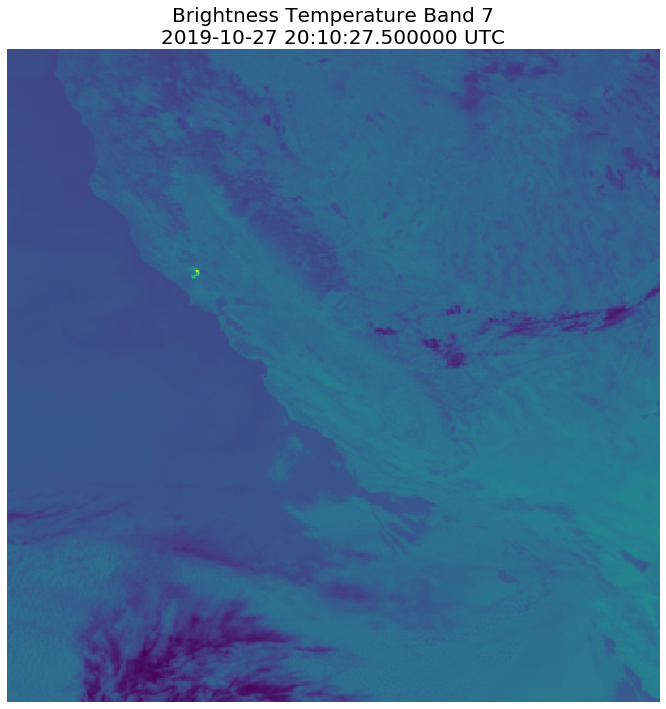

In [4]:
band_7 = goes_scan.GoesScan(
    filepath="ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C07_G17_s20193002010275_e20193002010344_c20193002010380.nc"
)
band_7.plot();

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:goes.downloader:Downloading s3://noaa-goes17/ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C01_G17_s20193002000275_e20193002000332_c20193002000379.nc to downloaded_data/noaa-goes17/ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C01_G17_s20193002000275_e20193002000332_c20193002000379.nc
INFO:goes.goes_scan:Processing scan...


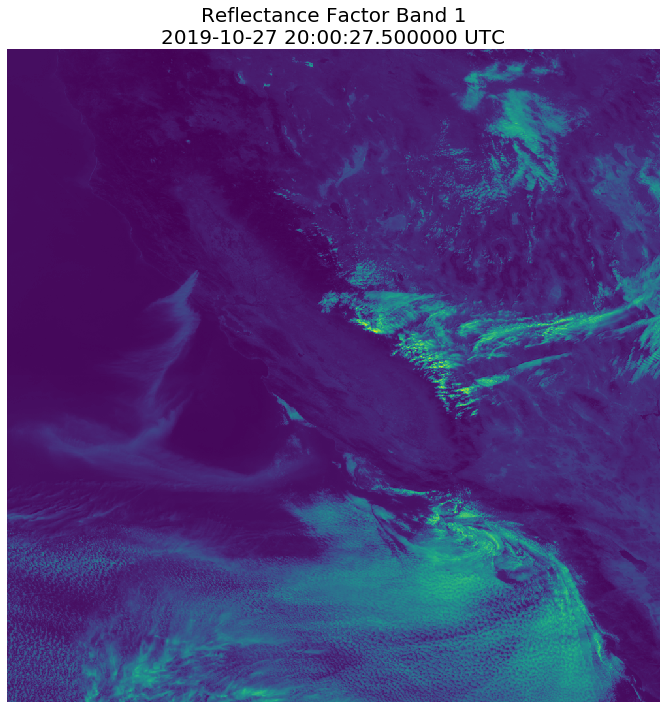

In [5]:
band_1 = goes_scan.GoesScan(
    filepath="ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C01_G17_s20193002000275_e20193002000332_c20193002000379.nc"
)
band_1.plot();

## Plotting

In [4]:
s3_scans = get_scans(
    satellite=Sattelite.GOES_17,
    channels=[7],
    regions=[Region.MESO_1],
    start=datetime.datetime(2019, 10, 25),
    end=datetime.datetime(2019, 10, 27, 12)
)

fig, _ = plt.subplots(figsize=(12, 12))
ani = animation.ArtistAnimation(
    fig, 
    artists=[[plot_image(scan)] for scan in s3_scans[::20]],
    interval=4000,
    repeat_delay=4000
)
ani.save('dynamic_images.gif', writer=animation.PillowWriter(fps=10))
plt.close(fig);

Currently on 2019-10-25 00:00 out of 2019-10-27 12:00
Currently on 2019-10-25 12:00 out of 2019-10-27 12:00
Currently on 2019-10-26 00:00 out of 2019-10-27 12:00
Currently on 2019-10-26 12:00 out of 2019-10-27 12:00
Currently on 2019-10-27 00:00 out of 2019-10-27 12:00
Currently on 2019-10-27 12:00 out of 2019-10-27 12:00
Completed.


## Processing

- https://www.star.nesdis.noaa.gov/goesr/docs/ATBD/Imagery.pdf
- https://www.goes-r.gov/users/docs/PUG-GRB-vol4.pdf  this one is more official and better (section 7.1 and on)
- https://www.ncdc.noaa.gov/sites/default/files/attachments/README_ABI-L1b-CMI_Provisional_Maturity.pdf
- https://www.goes-r.gov/products/docs/PUG-Appendix-X.pdf
- https://www.goes-r.gov/users/docs/PUG-main-vol1.pdf (document page 11 for scaling and 5.3.9)
- https://www.goes-r.gov/users/docs/PUG-L1b-vol3.pdf (5.1.3)

1. get scaled spectral radiance from ABI 1Lb sensor for bands 1 -16
3. unscale spectra, randiance
2. re-sample so that all bands are at 2km resolution
3. convert from spectral radiance
    1. bands 1 - 6 to reflectance factor (using scaling coefficients)
    2. bands 7 - 16 to brightness temperature (using planck calibration coefficients)
    
- radiometrically calibrated
    - (wikipedia) Spectral data acquired by satellite sensors are influenced by a number of factors, such as atmospheric absorption, scattering, sensor-target-illumination geometry, sensor calibration, and image data processing procedures, which tend to change through time
    - for example, light scattering can cause a land fixture to move when its actually in the same place, this data is calibrated such that this is not the case
- each radiance observation (`Rad`) has an accompanied data quality flag (`DQF`) which is a 0-3 ordinal (good_pixel_qf, conditionally_usable_pixel_qf, out_of_range_pixel_qf, no_value_pixel_qf)
    - we can filter on this for 0 and 1 if we wanted to
- images are resampled to fit the ABI fixed grid, meaning that images at two differnt times should overlap (in practice there are jumps cause this is hard)
    - on  June 19, 2018 (maybe -- from this https://www.weather.gov/media/notification/pdfs/scn18-66goes16imagerytransition.pdf)
- watts per square meter per steradian per micron (or 1/cm)
    - depending on view angle, the amount of a surface viewed will change (steradian), what is the watts per square meter per wavelength
- each wavelength has a difference native resolution from the ABI, most of which are 2km
    - 1, 3, and 5 are 1 km
    - 2 is 0.5km
- radiance is  a standard measurement for both the reflective and emissive wavelenghts, but its probably not what we want
    - for the reflective wavelengths (1 - 6) we probably want reflectance factor
        - radiance * kappa0
        - kappa0 is provided in the netcdf file
    - for the emissive wavelenghts (7 - 16) we probably want brightness temperature
        -  `[ fk2 / (alog((fk1 / ) + 1)) - bc1 ] / bc2`, where `alog` is the natural log
        - these variables are in each netcdf file
- L1b is level 1b which is a level of data processing, some of the processing is the radiometric calibration
    - The Level 0 algorithm decompresses and extracts the raw detector observation and calibration sample data from the CCSDS packets. The Level 1b algorithm radiometrically corrects the sample data, and navigates and resamples the radiometrically corrected sample data to the ABI fixed grid. 
- the L1b processed data then gets sent out throught the GOES Rebroadcasting Service
    - https://www.nesdis.noaa.gov/GOES-R-Series-Satellites
    - There is documentation on the image data being scaled to unsigned 16 bit shorts to limit data size, but I think that the data saved in s3 has undergone de-scaled already
    - https://www.goes-r.gov/users/docs/PUG-GRB-vol4.pdf (Table 7.1.3.6.1.1-1) look at the min/max and then look at min/max of `Rad` property
    - the type of scaled data is u16, but type of what we see is f32
    - per https://www.goes-r.gov/products/docs/PUG-Appendix-X.pdf we should see a scale, offset, and _Unsigned attribute for every scaled property
- if want the coordinates of a point, then we need to convert from ABI fixed coordinate system to lat-lon coordinates
    - https://www.goes-r.gov/users/docs/PUG-GRB-vol4.pdf (7,1.2.6)
- will we want to overlay Full, CONUS, and Mesoscale images on one another? We can, but its tricky

In [66]:
band_1.Rad.min()

<xarray.DataArray 'Rad' ()>
array(64.20716, dtype=float32)
Coordinates:
    t        datetime64[ns] ...
    y_image  float32 ...
    x_image  float32 ...

In [57]:
ds.Rad

<xarray.DataArray 'Rad' (y: 1000, x: 1000)>
array([[2.487076, 1.674969, 1.674969, ..., 0.050756, 0.050756, 0.050756],
       [1.674969, 1.674969, 2.487076, ..., 0.050756, 0.050756, 0.050756],
       [2.487076, 1.674969, 2.487076, ..., 0.050756, 0.050756, 0.050756],
       ...,
       [6.547606, 7.359713, 7.359713, ..., 0.050756, 0.050756, 0.050756],
       [7.359713, 7.359713, 6.547606, ..., 0.050756, 0.050756, 0.050756],
       [6.547606, 6.547606, 6.547606, ..., 0.050756, 0.050756, 0.050756]],
      dtype=float32)
Coordinates:
    t        datetime64[ns] 2017-02-28T00:01:01.288337024
  * y        (y) float32 0.1269536 0.1269256 0.1268976 ... 0.0990096 0.098981604
  * x        (x) float32 -0.006257 -0.0062289997 ... 0.021687001 0.021715
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:              ABI L1b Radiances
    standard_name:          toa_outgoing_radiance_per_unit_wavelength
    sensor_band_bit_depth:  10
    valid_range:            [   0 1022]
   

### Bands 1 - 6

1. un-scale???
2. convert to reflectance factor
    - radiance * kappa
    
The reflective bands support the characterization of clouds, vegetation, snow/ice, and aerosols. 

In [64]:
band_1 = download_scan(s3_object=s3_resource.Object(bucket_name="noaa-goes17", key="ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C01_G17_s20193002000275_e20193002000332_c20193002000379.nc"))

#### Un-scale

 For Table 3, the slope is the ratio
of the number of bits over the radiance range; the intercept is the slope times the negative
of the minimum radiance. Note that the radiance units differ between bands 1-6 and 7-16.


For Table 4, the slope is calculated as the inverse of the slope from Table 3, while the
intercept is negative of the ratio of the intercept to slope from Table 3.

#### Convert to reflectance factor

The Radiances product can be converted from radiances to reflectance factor or brightness temperature
using information provided in the product. For the reflective bands, conversion from radiance ν L to
reflectance factor ρ υf is computed as:

reflectance_factor = kappa_factor * randiance

where κ is the ‘kappa factor’. The kappa factor κ = ((π·d2
)/Esun) represents the incident Lambertianequivalent radiance, where d is the instantaneous Earth-Sun distance (in Astronomical Units) and Esun is the
solar irradiance in the respective bandpass (in W/(m2 µm)). The kappa factor is included in the product
metadata as the variable “kappa0”. The solar irradiance and Earth-Sun distance are also represented as
variables “esun” and “earth_sun_distance_anomaly_in_AU”, respectively.

In [103]:
band_1.kappa0.long_name

'Inverse of the incoming top of atmosphere radiance at current earth-sun distance (PI d2 esun-1)-1, where d is the ratio of instantaneous Earth-Sun distance divided by the mean Earth-Sun distance, esun is the bandpass-weighted solar irradiance and PI is a standard constant used to convert ABI L1b radiance to reflectance'

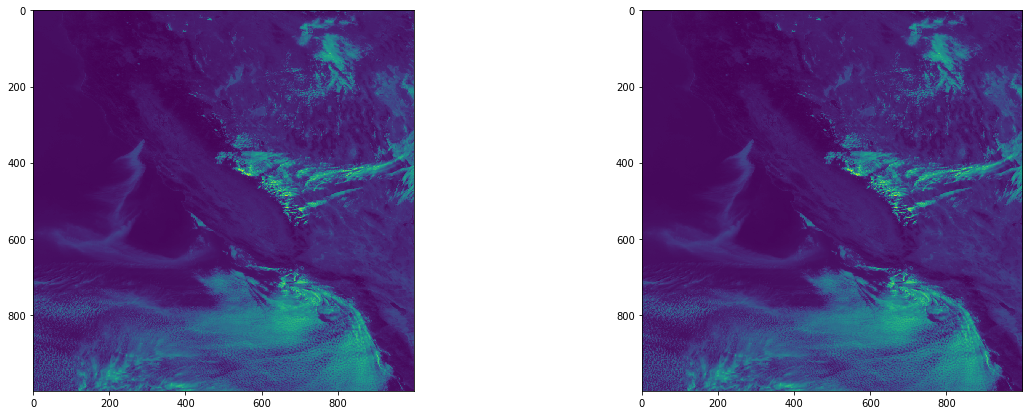

In [135]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 7))
axes[0].imshow(band_1.Rad)
axes[1].imshow(band_1.Rad * band_1.kappa0)

### Bands 7 - 16

1. un-scale??
2. convert to brightness temperature

T = [ fk2 / (alog((fk1 / Lλ) + 1)) - bc1 ] / bc2 

The
emissive bands support the characterization of the surface, clouds, water vapor, ozone, volcanic ash and
dust based on emissive properties.

In [19]:
band_7 = download_scan(s3_object=s3_resource.Object(bucket_name="noaa-goes17", key="ABI-L1b-RadM/2019/300/20/OR_ABI-L1b-RadM1-M6C07_G17_s20193002010275_e20193002010344_c20193002010380.nc"))

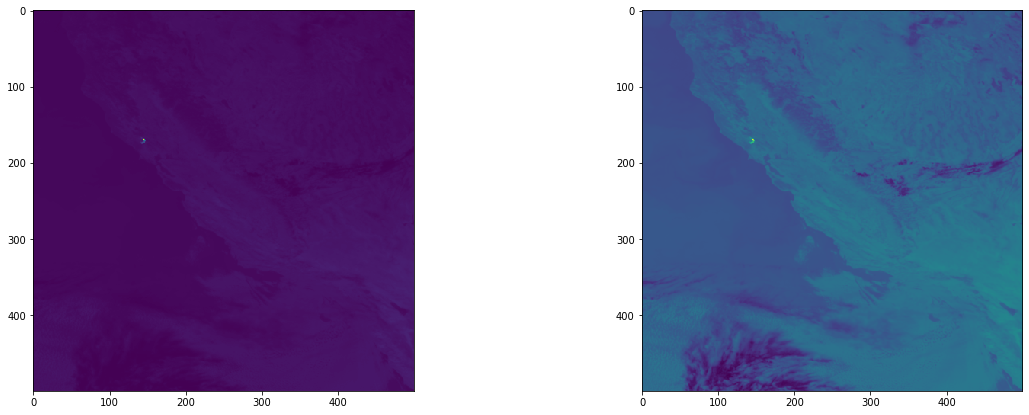

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 7))
axes[0].imshow(band_7.Rad)
axes[1].imshow((band_7.planck_fk2 / (np.log((band_7.planck_fk1 / band_7.Rad) + 1)) - band_7.planck_bc1) / band_7.planck_bc2)